In [2]:
from urllib import request
import nltk
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from textblob import TextBlob
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support, ConfusionMatrixDisplay, confusion_matrix, classification_report,f1_score
from mlxtend.evaluate import bias_variance_decomp
from sklearn.cluster import KMeans
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from collections import defaultdict
from sklearn.mixture import GaussianMixture
%matplotlib inline
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
def get_raw(url):
  response = request.urlopen(url) # open a connection to the specified url and get the server's response to the HTTP request
  raw = response.read().decode('utf-8-sig') # read the content of the HTTP response as a sequence of bytes and then decode these bytes into a Unicode string using the UTF-8 encoding. The result is the text content of the specified url.
  return raw

In [4]:
def get_raw_from_author_to_closing(title,author,url):
  raw= get_raw(url)
  opening_statement= '.*start.*ebook.*\n' # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object
  closing_statement= '.*end.*ebook.*\n'  # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object

  start_position= re.search(opening_statement,raw.lower()).end() # start position is the end position of the opening statement
  if re.search(title.lower(),raw[start_position:].lower()): # if opening statement is followed by title
    start_position += re.search(title.lower(),raw[start_position:].lower()).end() # update start position to be end of title
    if re.search((author).lower(),raw[start_position:].lower()): # if title is followed by author name
      start_position += re.search((author).lower(),raw[start_position:].lower()).end() #update start position to be end of author name

  end_position= re.search(closing_statement,raw.lower()).start() # end position is the start position of the closing statement
  return raw[start_position:end_position]

In [5]:
def get_tokens(raw):
  words= nltk.word_tokenize(raw)
  return words

In [6]:
def extract_partitions(title,author,url,num_partitions,num_words_per_partition):
  raw= get_raw_from_author_to_closing(title,author,url) # get raw text from url
  words= get_tokens(raw) # get list of words/tokens from raw text
  partitions= []
  for i in range(num_partitions):
    start_index = random.randint(0, len(words) - num_words_per_partition) # generates a random starting index within the range of valid indices for the words list i.e. in such a way that the selected partition will not go beyond the end of the list
    partition = ' '.join(words[start_index:start_index + num_words_per_partition]) # Extracts a consecutive sequence of num_words_per_partition words starting from a the random position start_index and extending up to start_index + num_words_per_partition and joins the selected words into a single string by using space ' ' as a separator to form a sentence-like structure
    partitions.append(partition) # saves the partition in the list of partitions
  return partitions

In [7]:
def extract_from_multiple_books(books_details,num_partitions,num_words_per_partition):
  dict={'Partition':[],'Label':[], 'Book Title':[], 'Book Author':[]} # will be used to save each partition with its label and the title and author it belongs to
  for i in range(len(books_details)):
    partitions= extract_partitions(books_details[i]['title'],books_details[i]['author'],books_details[i]['url'],num_partitions,num_words_per_partition)
    for partition in partitions:
      dict['Partition'].append(partition)
      dict['Label'].append(books_details[i]['label'])
      dict['Book Title'].append(books_details[i]['title'])
      dict['Book Author'].append(books_details[i]['author'])
  return dict

In [8]:
def extract_and_save(books_details,num_partitions,num_words_per_partition):
  dict= extract_from_multiple_books(books_details,num_partitions,num_words_per_partition)

  # Assign series for partitions, labels, titles, and authors
  partitions= pd.Series(dict['Partition'])
  labels= pd.Series(dict['Label'])
  titles= pd.Series(dict['Book Title'])
  authors= pd.Series(dict['Book Author'])

  # Construct a data frame from the above series
  data= pd.DataFrame({'Book Title':titles, 'Book Author':authors, 'Label':labels, 'Partition':partitions })

  # Save the data to a csv file
  data.to_csv('sample_partitions.csv', index=False, encoding= 'utf-8-sig')
  return data

In [9]:
# Book 1 Details https://www.gutenberg.org/cache/epub/3695/pg3695.txt
url1 = 'https://www.gutenberg.org/cache/epub/4081/pg4081.txt'
title1= 'The Alchemist'
author1= 'Ben Jonson'
label1= 'a'
dict1= {'title':title1, 'author':author1, 'url':url1, 'label':label1}

# Book 2 Details
url2= 'https://www.gutenberg.org/cache/epub/1656/pg1656.txt'
title2= 'Apology'
author2= 'Plato'
label2= 'b'
dict2= {'title':title2, 'author':author2, 'url':url2, 'label':label2}

# Book 3 Details
url3= 'https://www.gutenberg.org/cache/epub/996/pg996.txt'
title3= 'Don Quixote'
author3= 'Miguel de Cervantes Saavedra'
label3= 'c'
dict3= {'title':title3, 'author':author3, 'url':url3, 'label':label3}

# Book 4 Details
url4= 'https://www.gutenberg.org/cache/epub/766/pg766.txt'
title4= 'David Copperfield'
author4= 'Charles Dickens'
label4= 'd'
dict4= {'title':title4, 'author':author4, 'url':url4, 'label':label4}

# Book 5 Details
url5= 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt'
title5= 'The Odyssey'
author5= 'Homer'
label5= 'e'
dict5= {'title':title5, 'author':author5, 'url':url5, 'label':label5}

# Book 6 Details
url6= 'https://www.gutenberg.org/cache/epub/2554/pg2554.txt'
title6= 'Crime and Punishment'
author6= 'Fyodor Dostoyevsky'
label6= 'f'
dict6= {'title':title6, 'author':author6, 'url':url6, 'label':label6}

# All Books Details
books_details= [dict1, dict2, dict3, dict4,dict5, dict6]
books_details

[{'title': 'The Alchemist',
  'author': 'Ben Jonson',
  'url': 'https://www.gutenberg.org/cache/epub/4081/pg4081.txt',
  'label': 'a'},
 {'title': 'Apology',
  'author': 'Plato',
  'url': 'https://www.gutenberg.org/cache/epub/1656/pg1656.txt',
  'label': 'b'},
 {'title': 'Don Quixote',
  'author': 'Miguel de Cervantes Saavedra',
  'url': 'https://www.gutenberg.org/cache/epub/996/pg996.txt',
  'label': 'c'},
 {'title': 'David Copperfield',
  'author': 'Charles Dickens',
  'url': 'https://www.gutenberg.org/cache/epub/766/pg766.txt',
  'label': 'd'},
 {'title': 'The Odyssey',
  'author': 'Homer',
  'url': 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt',
  'label': 'e'},
 {'title': 'Crime and Punishment',
  'author': 'Fyodor Dostoyevsky',
  'url': 'https://www.gutenberg.org/cache/epub/2554/pg2554.txt',
  'label': 'f'}]

In [10]:
data= extract_and_save(books_details,num_partitions=200,num_words_per_partition=150)

In [11]:
data

,Book Title,Book Author,Label,Partition
0,The Alchemist,Ben Jonson,a,; and those that use election and a mean . For...
1,The Alchemist,Ben Jonson,a,"the young gentleman , Against his Spanish slop..."
2,The Alchemist,Ben Jonson,a,"; were not the pounds told out , Upon the seco..."
3,The Alchemist,Ben Jonson,a,in the reign of William Rufus . This he hurrie...
4,The Alchemist,Ben Jonson,a,. He will make Nature asham 'd of her long sle...
...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,"honest and jealous woman , after many scenes o..."
1196,Crime and Punishment,Fyodor Dostoyevsky,f,"thinking to myself of late , on my way here in..."
1197,Crime and Punishment,Fyodor Dostoyevsky,f,than twenty roubles a year to her hundred and ...
1198,Crime and Punishment,Fyodor Dostoyevsky,f,", why need you have come ? Your laughter , too..."


In [12]:
def clean_text_stem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_stemmed=' '.join([nltk.PorterStemmer().stem(word) for word in text_nostop])
  return text_stemmed

def clean_text_lem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_lemmatized= ' '.join([nltk.WordNetLemmatizer().lemmatize(word) for word in text_nostop])
  return text_lemmatized

data['Partition_stemmed']= data['Partition'].apply(lambda x: clean_text_stem(x))
data['Partition_lemmatized']= data['Partition'].apply(lambda x: clean_text_lem(x))
data

,Book Title,Book Author,Label,Partition,Partition_stemmed,Partition_lemmatized
0,The Alchemist,Ben Jonson,a,; and those that use election and a mean . For...,use elect mean diseas unskil think rude thing ...,use election mean disease unskilful think rude...
1,The Alchemist,Ben Jonson,a,"the young gentleman , Against his Spanish slop...",young gentleman spanish slop ana profan lewd s...,young gentleman spanish slop ana profane lewd ...
2,The Alchemist,Ben Jonson,a,"; were not the pounds told out , Upon the seco...",pound told upon second day fourth week eighth ...,pound told upon second day fourth week eighth ...
3,The Alchemist,Ben Jonson,a,in the reign of William Rufus . This he hurrie...,reign william rufu hurriedli adapt includ sati...,reign william rufus hurriedly adapted include ...
4,The Alchemist,Ben Jonson,a,. He will make Nature asham 'd of her long sle...,make natur asham long sleep art stepdam shall ...,make nature asham long sleep art stepdame shal...
...,...,...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,"honest and jealous woman , after many scenes o...",honest jealou woman mani scene hyster reproach...,honest jealous woman many scene hysteric repro...
1196,Crime and Punishment,Fyodor Dostoyevsky,f,"thinking to myself of late , on my way here in...",think late way train especi contribut calam mo...,thinking late way train especially contribute ...
1197,Crime and Punishment,Fyodor Dostoyevsky,f,than twenty roubles a year to her hundred and ...,twenti roubl year hundr twenti know build hope...,twenty rouble year hundred twenty know buildin...
1198,Crime and Punishment,Fyodor Dostoyevsky,f,", why need you have come ? Your laughter , too...",need come laughter came rememb saw plain dayli...,need come laughter came remember saw plain day...


Training and Testing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data['Partition_lemmatized'], data['Book Author'], test_size=0.2, random_state=42)

In [14]:
X_train.to_csv('X_train.csv', index=False, header=True, encoding= 'utf-8-sig')
X_test.to_csv('X_test.csv', index=False, header=True, encoding= 'utf-8-sig')
y_train.to_csv('y_train.csv', index=False, header=True, encoding= 'utf-8-sig')
y_test.to_csv('y_test.csv', index=False, header=True, encoding= 'utf-8-sig')

In [15]:
X_train= pd.read_csv('X_train.csv', encoding= 'utf-8-sig')
X_test= pd.read_csv('X_test.csv', encoding= 'utf-8-sig')
y_train= pd.read_csv('y_train.csv', encoding= 'utf-8-sig')
y_test= pd.read_csv('y_test.csv', encoding= 'utf-8-sig')

Vectorization function (tf-idf and bow)

In [16]:
def vectorize_text(data, column, method='tfidf'):
    if method == 'tfidf':
        vectorizer = TfidfVectorizer()
    elif method == 'bow':
        vectorizer = CountVectorizer()
    else:
        raise ValueError("Invalid method. Choose 'tfidf' or 'bow'.")

    vectorizer.fit(data[column])
    X_vectorized = vectorizer.transform(data[column])
    return X_vectorized, vectorizer

#K-means clustering

In [17]:
def perform_kmeans(X_train, X_test, n_clusters=6):
    kmeans = KMeans(n_clusters=6, random_state=42)
    kmeans.fit(X_train)
    train_cluster_labels = kmeans.predict(X_train)
    test_cluster_labels = kmeans.predict(X_test)
    return train_cluster_labels, test_cluster_labels

Print cluster

In [18]:
def print_cluster_data(X_test, test_cluster_labels, y_test):
    # Add cluster labels to the test data
    X_test_with_clusters = X_test.copy()
    X_test_with_clusters['Cluster'] = test_cluster_labels

    # Initialize a dictionary to store samples for each cluster
    cluster_samples = {}

    # Iterate over unique cluster labels
    for cluster_label in np.unique(test_cluster_labels):
        # Get indices of samples belonging to the current cluster
        indices = np.where(test_cluster_labels == cluster_label)[0]
        # Get the samples
        samples = X_test_with_clusters.iloc[indices]
        # Add the samples to the dictionary
        cluster_samples[cluster_label] = samples

    # Display the samples for each cluster
    for cluster_label, samples in cluster_samples.items():
        author = y_test.iloc[samples.index[0]]  # Get author name from y_test
        print(f"Cluster: {cluster_label}, Author: {author.values[0]}")  # Print cluster label and author name
        for i, sample in samples.iterrows():
            partition = sample['Partition_lemmatized']
            print(f"  {partition}\n")
        print()

Get Cluster Data (Dictionary form)

In [19]:
def get_cluster_data(X_test, test_cluster_labels, y_test):
    # Add cluster labels to the test data
    X_test_with_clusters = X_test.copy()
    X_test_with_clusters['Cluster'] = test_cluster_labels

    # Initialize a dictionary to store samples for each author
    author_samples = {}

    # Iterate over unique cluster labels
    for cluster_label in np.unique(test_cluster_labels):
        # Get indices of samples belonging to the current cluster
        indices = np.where(test_cluster_labels == cluster_label)[0]
        # Get the samples
        samples = X_test_with_clusters.iloc[indices]
        # Get the author for the current cluster
        author = y_test.iloc[samples.index[0]].values[0]
        # Add the samples to the dictionary
        if author in author_samples:
            author_samples[author].extend(samples['Partition_lemmatized'].tolist())
        else:
            author_samples[author] = samples['Partition_lemmatized'].tolist()

    return author_samples

Cluster Visualization/Distribution

In [20]:
def visualize_clusters(X_train, cluster_labels, y_train):
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train.toarray())  # Convert sparse matrix to dense array

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels
    df['Author'] = y_train.values

    # Create a mapping of cluster labels to majority author names
    cluster_to_majority_author = {}
    for cluster_label in df['Cluster'].unique():
        cluster_data = df[df['Cluster'] == cluster_label]
        majority_author = cluster_data['Author'].mode()[0]
        cluster_to_majority_author[cluster_label] = majority_author

    # Map cluster labels to majority author names
    df['Majority_Author'] = df['Cluster'].map(cluster_to_majority_author)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Majority_Author', data=df, palette='tab10')
    plt.title('PCA Visualization of Clusters (Author Names)')
    plt.show()

Kappa score against authors

In [21]:
def calculate_kappa_score(y_test, test_cluster_labels):
    cluster_to_majority_author = {}
    for cluster_label in np.unique(test_cluster_labels):
        indices = np.where(test_cluster_labels == cluster_label)[0]
        author_labels = y_test.iloc[indices]
        majority_author_label = author_labels.value_counts().idxmax()
        cluster_to_majority_author[cluster_label] = majority_author_label

    test_cluster_author = [cluster_to_majority_author[label] for label in test_cluster_labels]

    kappa = cohen_kappa_score(y_test, test_cluster_author)
    return kappa

#Results of tf-idf - - k-means

In [ ]:
X_train_tfidf, tfidf_vectorizer = vectorize_text(X_train, 'Partition_lemmatized', method='tfidf')
X_test_tfidf = tfidf_vectorizer.transform(X_test['Partition_lemmatized'])

Clustering

In [ ]:
train_cluster_labels_tfidf, test_cluster_labels_tfidf = perform_kmeans(X_train_tfidf, X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster data (tf-idf - - k-means)

In [ ]:
get_cluster_data(X_test, test_cluster_labels_tfidf, y_test)

{'Miguel de Cervantes Saavedra': ['many spear held front quixote turning round cry sancho knew saw hanging oak head downwards dapple forsake distress close beside cide hamete observes seldom saw sancho panza without seeing dapple dapple without seeing sancho panza attachment loyalty one quixote went unhooked sancho soon found ground looked rent huntingcoat grieved heart thought got patrimonial estate suit meanwhile slung mighty boar across back mule',
  'fall made inward resolution yield commending might soul lady dulcinea made mind listen music let know gave pretended sneeze damsel little delighted wanted quixote hear tuned harp altisidora running hand across string began ballad thou art bed holland sheet alying night till morn outstretched leg asleep thou valiant knight famed manchegan breed purity virtue gold araby give ear unto suffering maid wellgrown evilstarr',
  'give petticoat boot best bravest trimmed gold galloon happy fair thy mighty arm enfold even sit beside thy bed scrat

Cluster Distribution (tf-idf - - k-means)

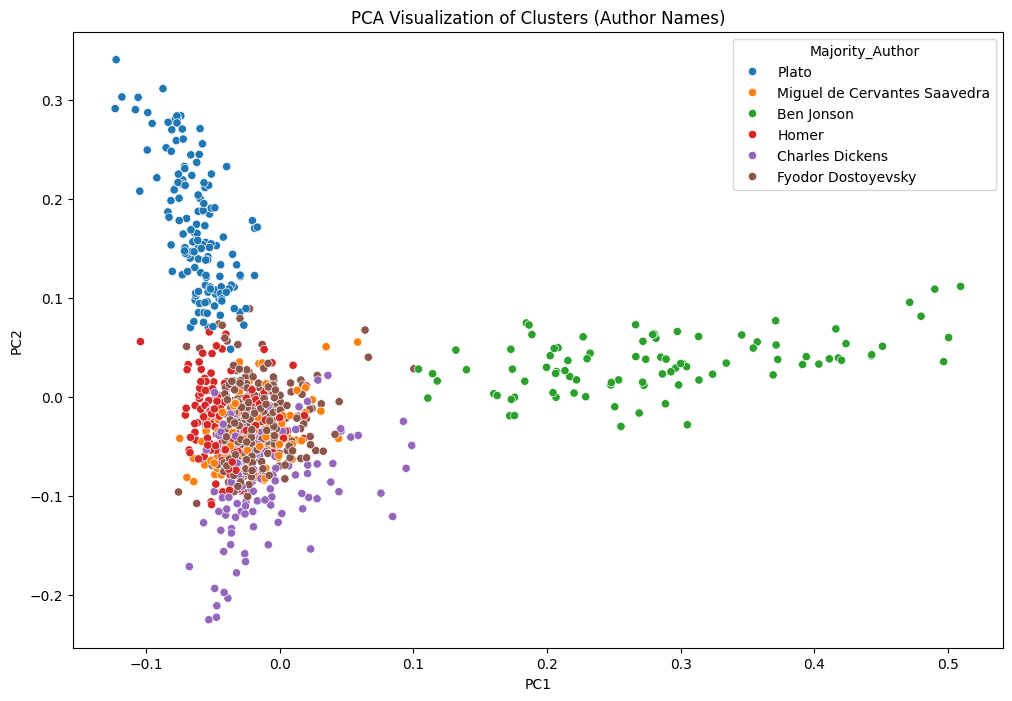

In [ ]:
visualize_clusters(X_train_tfidf, train_cluster_labels_tfidf, y_train)

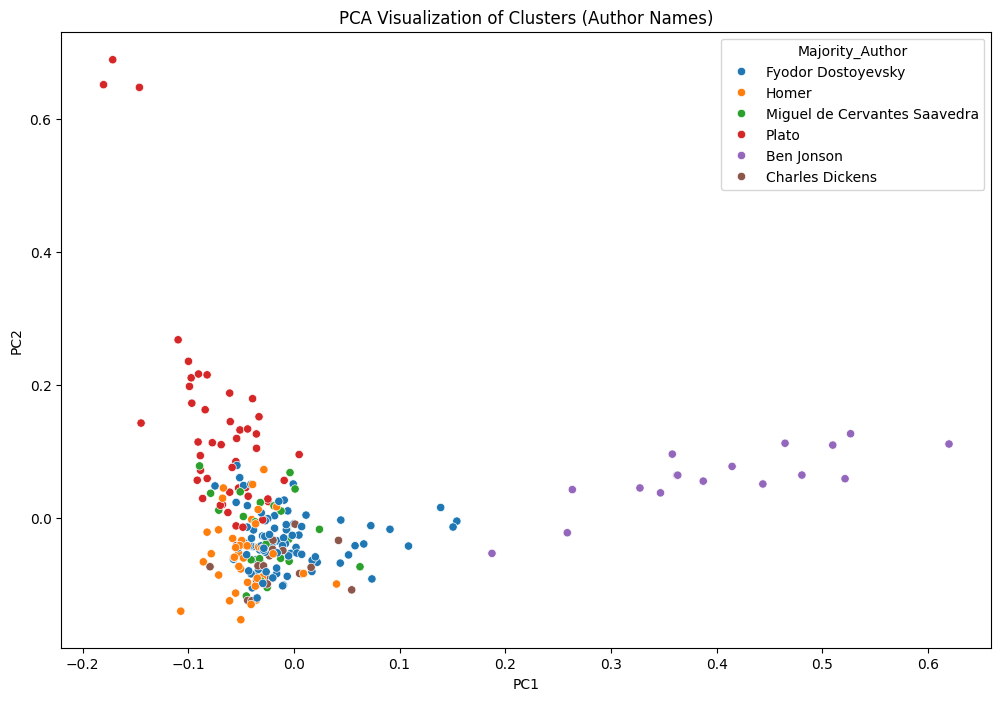

In [ ]:
visualize_clusters(X_test_tfidf, test_cluster_labels_tfidf, y_test)

Kappa score against authors for tf-idf - - k-means

In [ ]:
kappa_tfidf_test = calculate_kappa_score(y_test, test_cluster_labels_tfidf)
print(f"Cohen's Kappa (TF-IDF): {kappa_tfidf_test}")

Cohen's Kappa (TF-IDF): 0.7253318906321529


In [ ]:
kappa_tfidf_train = calculate_kappa_score(y_train, train_cluster_labels_tfidf)
print(f"Cohen's Kappa (TF-IDF): {kappa_tfidf_train}")

Cohen's Kappa (TF-IDF): 0.7610353051569769


#Results of bow - - k-means

Vectorization using bow

In [ ]:
X_train_bow, bow_vectorizer = vectorize_text(X_train, 'Partition_lemmatized', method='bow')
X_test_bow = bow_vectorizer.transform(X_test['Partition_lemmatized'])

Clustering

In [ ]:
train_cluster_labels_bow, test_cluster_labels_bow = perform_kmeans(X_train_bow, X_test_bow)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster data (BOW -- k-means)

In [ ]:
get_cluster_data(X_test, test_cluster_labels_bow, y_test)

{'Plato': ['speaking superhuman wisdom may fail describe say speaks falsely taking away character men athens must beg interrupt even seem say something extravagant word speak mine refer witness worthy credit witness shall god delphi—he tell wisdom sort must known chaerephon early friend mine also friend shared recent exile people returned',
  'said superior wisdom courage virtue demean way shameful conduct seen men reputation condemned behaving strangest manner seemed fancy going suffer something dreadful died could immortal allowed live think dishonour state stranger coming would said eminent men athens athenian give honour command better woman say thing ought done u reputation done',
  'brother know command god believe greater good ever happened state service god nothing go persuading old young alike take thought person property first chiefly care greatest improvement soul tell virtue given money virtue come money every good man public well private teaching doctrine corrupts youth mi

Cluster distribution/visualization (bow -- k-means)

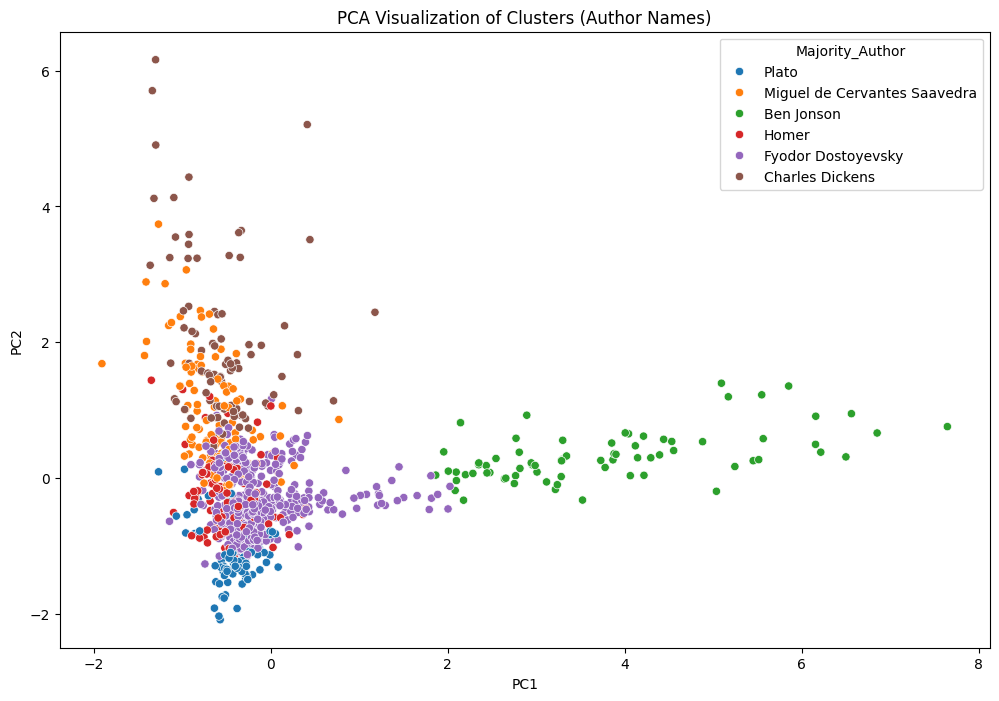

In [ ]:
visualize_clusters(X_train_bow, train_cluster_labels_bow, y_train)

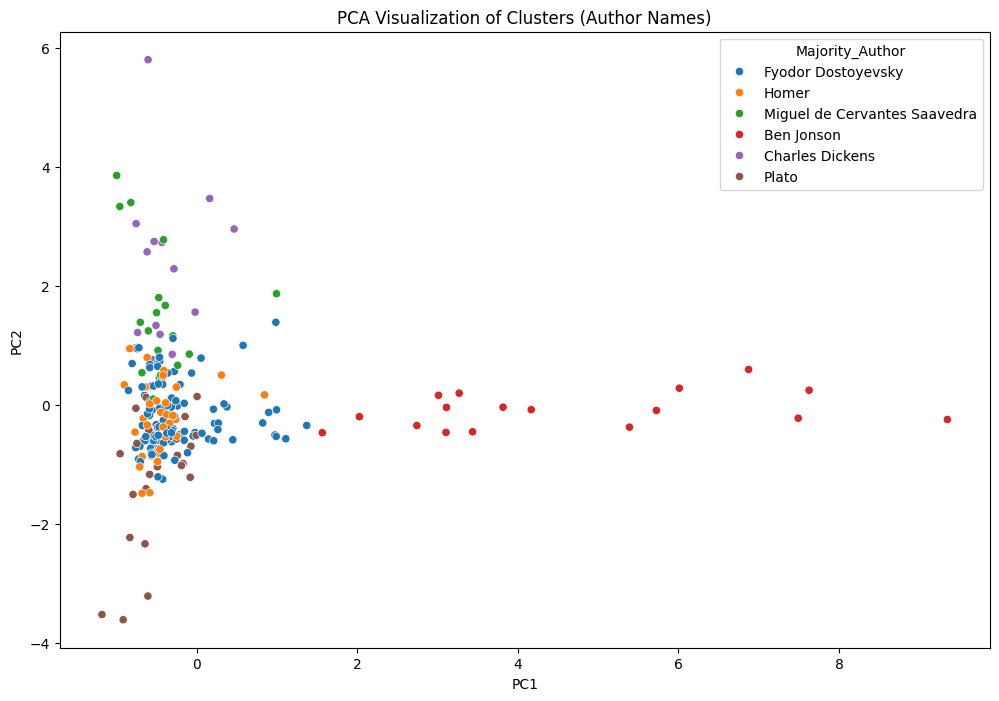

In [ ]:
visualize_clusters(X_test_bow, test_cluster_labels_bow, y_test)

Kappa score against authors for bow - - k-means

In [ ]:
kappa_bow_test = calculate_kappa_score(y_test, test_cluster_labels_bow)
print(f"Cohen's Kappa (BOW): {kappa_bow_test}")

Cohen's Kappa (BOW): 0.5482282853774072


In [ ]:
kappa_bow_train = calculate_kappa_score(y_train, train_cluster_labels_bow)
print(f"Cohen's Kappa (BOW): {kappa_bow_train}")

Cohen's Kappa (BOW): 0.565123170715787


Coherence

In [ ]:
dict_1_train = get_cluster_data(X_train, train_cluster_labels_tfidf, y_train)
dict_2_train = get_cluster_data(X_train, train_cluster_labels_bow, y_train)

In [ ]:
dict_1_test = get_cluster_data(X_test, test_cluster_labels_tfidf, y_test)
dict_2_test = get_cluster_data(X_test, test_cluster_labels_bow, y_test)

In [ ]:
dict_1_train

{'Miguel de Cervantes Saavedra': ['offering token show buried saint point coming said sancho tell greater work bring dead man life kill giant answer easy replied quixote greater work bring life dead man got said sancho case fame bring dead life give sight blind cure cripple restore health sick whose tomb lamp burning whose chapel filled devout folk knee adoring relic better fame',
  'gave law lacedemonians could pronounced better decision great panza given let morning audience close see señor governor dinner entirely liking ask for—fair play said sancho give dinner let rain case question despatch twinkling majordomo kept word felt conscience kill wise governor hunger particularly intended done night playing last joke commissioned practise upon came pas dined day',
  'god gentleman send shall see man frightened lion get good fellow keeper open cage turn beast midst plain let know quixote la mancha spite teeth enchanter send said gentleman worthy knight shown sort curd doubt softened sku

In [ ]:
dict_2_test

{'Plato': ['speaking superhuman wisdom may fail describe say speaks falsely taking away character men athens must beg interrupt even seem say something extravagant word speak mine refer witness worthy credit witness shall god delphi—he tell wisdom sort must known chaerephon early friend mine also friend shared recent exile people returned',
  'said superior wisdom courage virtue demean way shameful conduct seen men reputation condemned behaving strangest manner seemed fancy going suffer something dreadful died could immortal allowed live think dishonour state stranger coming would said eminent men athens athenian give honour command better woman say thing ought done u reputation done',
  'brother know command god believe greater good ever happened state service god nothing go persuading old young alike take thought person property first chiefly care greatest improvement soul tell virtue given money virtue come money every good man public well private teaching doctrine corrupts youth mi

Coherence

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_coherence(dict_1, dict_2):
    coherence_scores = {}

    for author in dict_1.keys():
        if author in dict_2:
            # Concatenate all samples for the author from both dictionaries
            all_samples = dict_1[author] + dict_2[author]

            # Initialize a TF-IDF vectorizer
            vectorizer = TfidfVectorizer()
            tfidf_matrix = vectorizer.fit_transform(all_samples)

            # Calculate cosine similarity between the samples
            similarity_matrix = cosine_similarity(tfidf_matrix)

            # Get the similarity score between the samples from dict_1 and dict_2
            similarity_score = similarity_matrix[:len(dict_1[author]), len(dict_1[author]):].mean()

            coherence_scores[author] = similarity_score

    return coherence_scores

In [ ]:
coherence_scores_train = calculate_coherence(dict_1_train, dict_2_train)
for author, score in coherence_scores_train.items():
    print(f"Coherence score for {author}: {score}")

Coherence score for Miguel de Cervantes Saavedra: 0.045457441223598787
Coherence score for Homer: 0.051691384232512405
Coherence score for Charles Dickens: 0.03917218030293201
Coherence score for Ben Jonson: 0.02156732250244224
Coherence score for Plato: 0.06111689368073829


In [ ]:
coherence_scores_test = calculate_coherence(dict_1_test, dict_2_test)
for author, score in coherence_scores_test.items():
    print(f"Coherence score for {author}: {score}")

Coherence score for Miguel de Cervantes Saavedra: 0.08319314217530022
Coherence score for Homer: 0.06943731394792482
Coherence score for Charles Dickens: 0.09272365988432002
Coherence score for Ben Jonson: 0.1481237302001635
Coherence score for Fyodor Dostoyevsky: 0.027318542503272536
Coherence score for Plato: 0.07211644230644236


Silhouette

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
#X_test_tfidf
#test_cluster_labels_tfidf
silhouette_avg_train = silhouette_score(X_train_tfidf, train_cluster_labels_tfidf)
print("Silhouette Score:", silhouette_avg_train)

Silhouette Score: 0.011126312712061022


In [ ]:
silhouette_avg_test = silhouette_score(X_test_bow, test_cluster_labels_bow)
print("Silhouette Score:", silhouette_avg_test)

Silhouette Score: 0.01428102892257775


# Hierarchical Clustering


In [ ]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from yellowbrick.text import TSNEVisualizer
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# Function to calculate kappa score against authors

In [ ]:
def calculate_kappa_score(y_test, test_cluster_labels):
    cluster_to_majority_author = {}
    for cluster_label in np.unique(test_cluster_labels):
        indices = np.where(test_cluster_labels == cluster_label)[0]
        author_labels = y_test.iloc[indices]
        majority_author_label = author_labels.value_counts().idxmax()
        cluster_to_majority_author[cluster_label] = majority_author_label

    test_cluster_author = [cluster_to_majority_author[label] for label in test_cluster_labels]

    kappa = cohen_kappa_score(y_test, test_cluster_author)
    return kappa

# Function to get cluster data & calculate coherence score against authors

In [ ]:
def get_cluster_data(X_test, test_cluster_labels, y_test):
    # Add cluster labels to the test data
    X_test_with_clusters = X_test.copy()
    X_test_with_clusters['Cluster'] = test_cluster_labels

    # Initialize a dictionary to store samples for each author
    author_samples = {}

    # Iterate over unique cluster labels
    for cluster_label in np.unique(test_cluster_labels):
        # Get indices of samples belonging to the current cluster
        indices = np.where(test_cluster_labels == cluster_label)[0]
        # Get the samples
        samples = X_test_with_clusters.iloc[indices]
        # Get the author for the current cluster
        author = y_test.iloc[samples.index[0]].values[0]
        # Add the samples to the dictionary
        if author in author_samples:
            author_samples[author].extend(samples['Partition_lemmatized'].tolist())
        else:
            author_samples[author] = samples['Partition_lemmatized'].tolist()

    return author_samples

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_coherence(dict_1, dict_2):
    coherence_scores = {}

    for author in dict_1.keys():
        if author in dict_2:
            # Concatenate all samples for the author from both dictionaries
            all_samples = dict_1[author] + dict_2[author]

            # Initialize a TF-IDF vectorizer
            vectorizer = TfidfVectorizer()
            tfidf_matrix = vectorizer.fit_transform(all_samples)

            # Calculate cosine similarity between the samples
            similarity_matrix = cosine_similarity(tfidf_matrix)

            # Get the similarity score between the samples from dict_1 and dict_2
            similarity_score = similarity_matrix[:len(dict_1[author]), len(dict_1[author]):].mean()

            coherence_scores[author] = similarity_score

    return coherence_scores

#Plotting the dendrogram

In [ ]:
text_embedding = {
    'bow' : X_train_bow.toarray(),
    'tfidf' : X_train_tfidf.toarray()
}

# Hierarchical clustering for **bow**

In [ ]:
X_train_bow, bow_vectorizer = vectorize_text(X_train, 'Partition_lemmatized', method='bow')
X_test_bow = bow_vectorizer.transform(X_test['Partition_lemmatized'])

Text(0.5, 0, 'data')

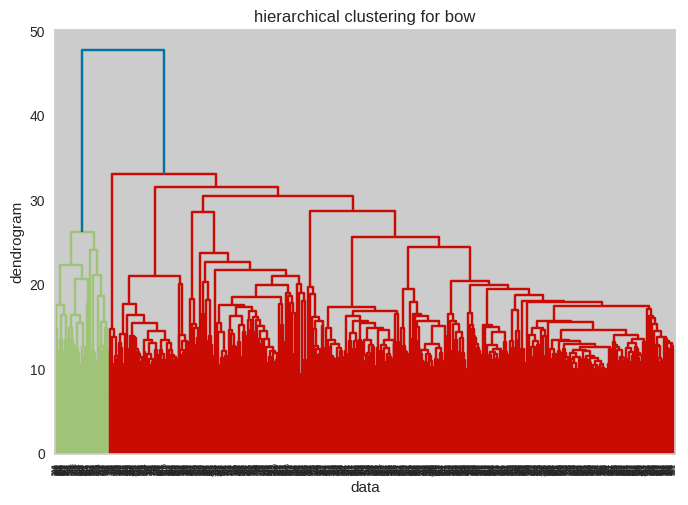

In [ ]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

dendrogram = sch.dendrogram(sch.linkage(text_embedding['bow'], method='ward'))
hc_bow = AgglomerativeClustering(n_clusters=6, metric = 'euclidean', linkage = 'ward')
y_hc = hc_bow.fit_predict(text_embedding['bow'])
plt.title('hierarchical clustering for bow')
plt.ylabel('dendrogram')
plt.xlabel('data')

# Calculating Kappa score for AgglomerativeClustering with bow

In [ ]:
kappa_bow_train = calculate_kappa_score(y_train, hc_bow.labels_)
print(f"Cohen's Kappa (Hierarchical-BOW): {kappa_bow_train}")

Cohen's Kappa (Hierarchical-BOW): 0.4473489432193334


# Hierarchical clustering for **tfidf**

In [ ]:
X_train_tfidf, tfidf_vectorizer = vectorize_text(X_train, 'Partition_lemmatized', method='tfidf')
X_test_tfidf = tfidf_vectorizer.transform(X_test['Partition_lemmatized'])

Text(0.5, 0, 'data')

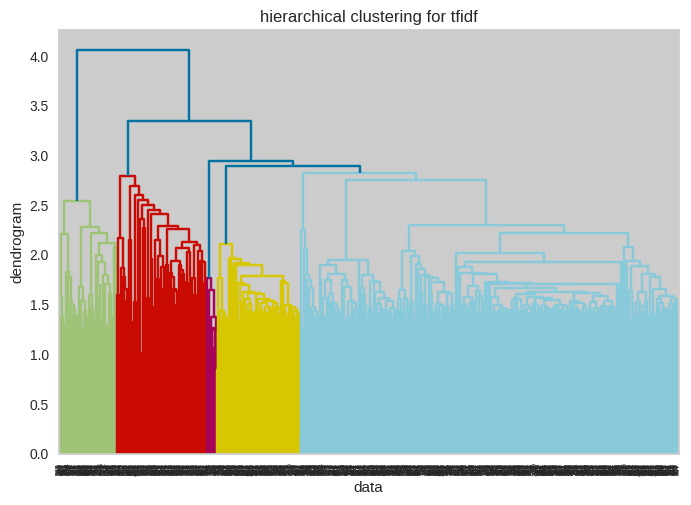

In [ ]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

dendrogram = sch.dendrogram(sch.linkage(text_embedding['tfidf'], method='ward'))
hc_tfidf = AgglomerativeClustering(n_clusters=6, metric = 'euclidean', linkage = 'ward')
y_hc = hc_tfidf.fit_predict(text_embedding['tfidf'])
plt.title('hierarchical clustering for tfidf')
plt.ylabel('dendrogram')
plt.xlabel('data')

# Calculating Kappa score for AgglomerativeClustering with tfidf

In [ ]:
kappa_tfidf_train = calculate_kappa_score(y_train, hc_tfidf.labels_)
print(f"Cohen's Kappa (Hierarchical-TFIDF): {kappa_tfidf_train}")

Cohen's Kappa (Hierarchical-TFIDF): 0.489609173240535


# Visualizing silhouette score for AgglomerativeClustering with both bow and tfidf embeddings

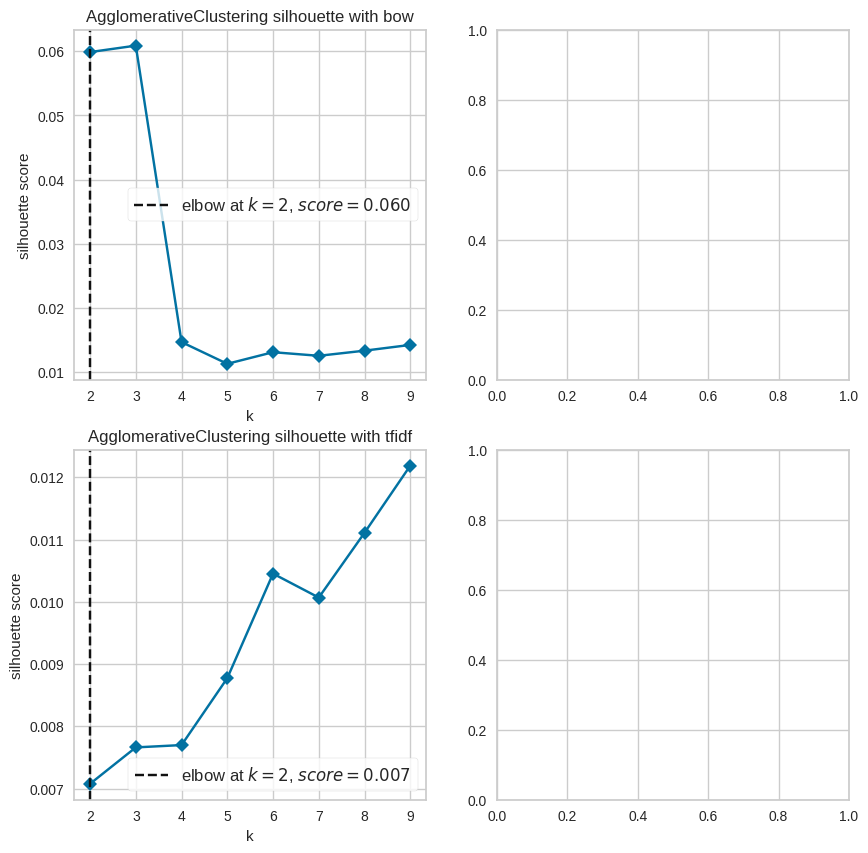

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
# from yellowbrick.features import FeatureImportances
# from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
# from sklearn.linear_model import LogisticRegression

x_size , y_size =2,2
fig, axes = plt.subplots(2, 2,figsize=(10,10))

model = AgglomerativeClustering()

visualgrid = []
for i in range(len(text_embedding.keys())):
    ax = axes[i % x_size][i // y_size]
    ax.set_title(text_embedding.keys())
    visualgrid.append(KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=False, ax=axes[i%x_size][i//y_size], title = type(model).__name__ + ' silhouette with ' + list(text_embedding.keys())[i]))

for vis,key in zip(visualgrid,text_embedding.keys()):
    vis.fit(text_embedding[key])
    vis.ax.set_title(key)
    vis.finalize()

plt.show()

# Calculating coherence for AgglomerativeClustering with both bow and tfidf embeddings

In [ ]:
dict_1_train_hc_tfidf = get_cluster_data(X_train, hc_tfidf.labels_, y_train)
dict_2_train_hc_bow = get_cluster_data(X_train, hc_bow.labels_, y_train)
coherence_scores_train = calculate_coherence(dict_1_train_hc_tfidf, dict_2_train_hc_bow)
for author, score in coherence_scores_train.items():
    print(f"Coherence score for {author}: {score}")


Coherence score for Plato: 0.025978770433824287
Coherence score for Ben Jonson: 0.05516909277266214
Coherence score for Charles Dickens: 0.15278044022318765
Coherence score for Miguel de Cervantes Saavedra: 0.042832858644058135


# Expectation-Maximization algorithm


In [ ]:
def em_model(X_train,num_clusters):
  bic_values = []

  gmm = GaussianMixture(n_components = num_clusters,random_state = 42)
  label = gmm.fit_predict(X_train.toarray())
  bic_values.append(gmm.bic(X_train.toarray()))

  return gmm, bic_values

In [ ]:
def em_plot(num_clusters,bic_values):
  plt.plot(num_clusters,bic_values,marker = "o")
  plt.xlabel('Number of Clusters')
  plt.ylabel('BIC Value')
  plt.title('BIC for EM Clustering')
  plt.show()

In [ ]:
#X_train_tfidf, vectorizer_tfidf = vectorize_text(X_train,"Partition_lemmatized")
#X_train_bow, vectorizer_bow = vectorize_text(X_train,"Partition_lemmatized","bow")

## TFIDF results

In [ ]:
#model, bic = em_model(X_train_bow,6)

# skip

In [22]:
! pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 37.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.21.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.0 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.0 which is incompatible.


In [23]:
from gensim.corpora import Dictionary
from gensim import models
import pyLDAvis.gensim
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from pprint import pprint
from nltk import ngrams

# N gram vectorization

In [32]:
def ngram_vect(data,n):
  word = word_tokenize(data)
  n_grams = list(ngrams(word,n))
  return n_grams

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LDA vectorization

In [ ]:
def vectorize_lda(columns, vect_type="tfidf"):
    if vect_type == "ngram":
        n_grams = ngrams(data[columns], 3)
        documents_ngram = [' '.join(gram) for gram in n_grams]
        tokens = [word_tokenize(doc) for doc in documents_ngram]
    else:
        tokens = [word_tokenize(doc) for doc in data[columns]]

    dictionary = Dictionary(tokens)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokens]

    if vect_type == "tfidf":
        tfidf_model = models.TfidfModel(corpus)
        corpus = tfidf_model[corpus]
    temp = dictionary[0]
    lda_model = models.LdaModel(corpus, num_topics=6, id2word=dictionary.id2token, passes=10, random_state=42)

    return lda_model, corpus, dictionary

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def display_topics_coherence(model,corpus):
  topics = model.top_topics(corpus)
  avg_topic_coherence = sum([t[1] for t in topics]) / 6
  print('Average topic coherence: %.4f.' % avg_topic_coherence)


  pprint(topics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def lda_plot(model,corpus,dictionary):
  pyLDAvis.enable_notebook()
  vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=dictionary)
  return vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lda with tfidf

In [ ]:
lda, corpus,dic = vectorize_lda("Partition_lemmatized")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
display_topics_coherence(lda,corpus)

Average topic coherence: -5.1379.
[([(0.0061892956, 'sub'),
   (0.0061108368, 'face'),
   (0.0041157147, 'sir'),
   (0.0038517483, 'sancho'),
   (0.0037063248, 'shall'),
   (0.0034046082, 'said'),
   (0.0033217922, 'ulysses'),
   (0.0032341434, 'dol'),
   (0.0032187598, 'quixote'),
   (0.0031383883, 'one'),
   (0.0030263255, 'come'),
   (0.0028429672, 'may'),
   (0.0028148547, 'give'),
   (0.002811897, 'house'),
   (0.002734296, 'see'),
   (0.002707448, 'u'),
   (0.0026502786, 'would'),
   (0.0026371416, 'say'),
   (0.0026303304, 'let'),
   (0.0026061004, 'good')],
  -2.519889086311407),
 ([(0.004464599, 'socrates'),
   (0.0037513953, 'death'),
   (0.0034974448, 'men'),
   (0.003090356, 'wise'),
   (0.0029736, 'evil'),
   (0.00295683, 'man'),
   (0.0028983925, 'say'),
   (0.0027381054, 'nothing'),
   (0.002567601, 'god'),
   (0.0024754263, 'apology'),
   (0.0024393531, 'would'),
   (0.0024042833, 'raskolnikov'),
   (0.0023700404, 'meletus'),
   (0.0023497976, 'wisdom'),
   (0.002339596

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
plot = lda_plot(lda,corpus,dic)
plot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.081286 -0.023499       1        1  44.053312
2     -0.047568 -0.055342       2        1  15.099859
1     -0.013960  0.020819       3        1  10.960507
5     -0.006494  0.004021       4        1  10.372066
0     -0.009010  0.036992       5        1  10.199714
3     -0.004254  0.017010       6        1   9.314542, topic_info=          Term       Freq      Total Category  logprob  loglift
2233        mr  14.000000  14.000000  Default  30.0000  30.0000
2232  micawber   6.000000   6.000000  Default  29.0000  29.0000
24         sub  19.000000  19.000000  Default  28.0000  28.0000
316        nei   3.000000   3.000000  Default  27.0000  27.0000
1509  socrates   8.000000   8.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
276        saw   1.093071   7.673411   Topic6  -6.3545   0.4248
2233        mr   1.175691  14.200746   Topic6  -6.2817  -0.1178
166        way   1.116931  11.031880   Topic6  -6.3329   0.0834
156        one   1.161546  17.568290   Topic6  -6.2938  -0.3428
1012   quixote   1.105155  12.516670   Topic6  -6.3435  -0.0535

[417 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
302       6  0.708311         1
303       6  0.618010         2
1371      6  0.851943         5
681       6  0.823101         6
1603      1  0.283044   accuser
...     ...       ...       ...
1662      1  0.239286     wrong
1662      3  0.239286     wrong
1662      4  0.239286     wrong
1662      6  0.239286     wrong
1746      2  0.810748  xenophon

[791 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 6, 1, 4])

bow with lda

In [ ]:
lda, corpus, dictionary = vectorize_lda("Partition_lemmatized",vect_type = "bow")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
display_topics_coherence(lda,corpus)

Average topic coherence: -2.2957.
[([(0.013434429, 'one'),
   (0.013228493, 'said'),
   (0.008301333, 'shall'),
   (0.007780559, 'may'),
   (0.0076627205, 'sir'),
   (0.00766255, 'sancho'),
   (0.0069443355, 'say'),
   (0.0064627053, 'would'),
   (0.006352526, 'give'),
   (0.0062379255, 'face'),
   (0.006054862, 'man'),
   (0.0059117675, 'quixote'),
   (0.0058791228, 'good'),
   (0.005780933, 'see'),
   (0.0055701253, 'sub'),
   (0.005470775, 'make'),
   (0.0054478236, 'know'),
   (0.005277512, 'come'),
   (0.0052322242, 'let'),
   (0.005052629, 'u')],
  -1.9156096869761117),
 ([(0.008104684, 'hand'),
   (0.007790743, 'could'),
   (0.0071118237, 'one'),
   (0.0067383396, 'went'),
   (0.0065487702, 'said'),
   (0.0063718385, 'upon'),
   (0.005909739, 'ulysses'),
   (0.0058303867, 'come'),
   (0.005415698, 'made'),
   (0.0053843656, 'would'),
   (0.0051562, 'without'),
   (0.0049382946, 'room'),
   (0.0048131426, 'though'),
   (0.004723123, 'came'),
   (0.0045873444, 'time'),
   (0.00437

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
plot = lda_plot(lda,corpus,dic)
plot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.020444 -0.000092       1        1  23.760260
0      0.054690 -0.049732       2        1  17.776097
1      0.060063 -0.089445       3        1  17.643496
2     -0.169961 -0.032642       4        1  17.516620
3      0.029689  0.068001       5        1  12.048525
5      0.005075  0.103910       6        1  11.255001, topic_info=        Term        Freq       Total Category  logprob  loglift
6       face  333.000000  333.000000  Default  30.0000  30.0000
2233      mr  245.000000  245.000000  Default  29.0000  29.0000
24       sub  201.000000  201.000000  Default  28.0000  28.0000
4        dol   97.000000   97.000000  Default  27.0000  27.0000
2423   sonia   61.000000   61.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
56       see   27.994598  272.887318   Topic6  -5.3652  -0.0927
40      come   27.975695  280.931798   Topic6  -5.3659  -0.1224
125     time   26.644954  238.975636   Topic6  -5.4146  -0.0094
455    first   21.634148  131.033953   Topic6  -5.6230   0.3832
124   though   21.058679  157.102793   Topic6  -5.6499   0.1748

[472 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
302       5  0.928206      1
723       4  0.881005   1616
303       5  0.955288      2
304       5  0.910527      3
305       5  0.792444      4
...     ...       ...    ...
1504      1  0.023157  youth
1504      2  0.069471  youth
1504      3  0.046314  youth
1504      4  0.648394  youth
1504      5  0.185255  youth

[1162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 3, 4, 6])

bigram with lda

In [ ]:
lda, corpus, dic = vectorize_lda("Partition_lemmatized", vect_type = "ngram")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
display_topics_coherence(lda,corpus)

Average topic coherence: -1.5846.
[([(0.0122291325, 'say'),
   (0.01095039, 'men'),
   (0.010800556, 'man'),
   (0.010593451, 'death'),
   (0.010569275, 'may'),
   (0.010273631, 'god'),
   (0.009934593, 'socrates'),
   (0.007343291, 'evil'),
   (0.0069720675, 'life'),
   (0.006864111, 'know'),
   (0.006540488, 'answer'),
   (0.006426607, 'meletus'),
   (0.006275405, 'believe'),
   (0.006016128, 'nothing'),
   (0.0055791833, 'like'),
   (0.005386792, 'truth'),
   (0.005312685, 'must'),
   (0.0052017868, 'many'),
   (0.005192479, 'defence'),
   (0.004788166, 'whether')],
  -1.1003974272302466),
 ([(0.009626024, 'sancho'),
   (0.00821545, 'quixote'),
   (0.0068544983, 'ulysses'),
   (0.0057960125, 'see'),
   (0.0054609, 'may'),
   (0.0050419527, 'come'),
   (0.0050061955, 'god'),
   (0.004937883, 'house'),
   (0.004871347, 'go'),
   (0.0045533045, 'u'),
   (0.0043996656, 'went'),
   (0.004264705, 'let'),
   (0.0042489395, 'say'),
   (0.0041392935, 'shall'),
   (0.0041184174, 'two'),
   (0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
plot = lda_plot(lda,corpus,dic)
plot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.013802  0.107544       1        1  30.030704
5      0.015982  0.140933       2        1  27.463923
2     -0.208779 -0.021848       3        1  15.490717
3      0.050804 -0.055133       4        1  11.181340
0      0.122732 -0.038890       5        1   8.613241
1      0.005460 -0.132605       6        1   7.220075, topic_info=        Term        Freq       Total Category  logprob  loglift
43      face  942.000000  942.000000  Default  30.0000  30.0000
4658      mr  766.000000  766.000000  Default  29.0000  29.0000
100      sub  553.000000  553.000000  Default  28.0000  28.0000
3704  sancho  540.000000  540.000000  Default  27.0000  27.0000
94       sir  571.000000  571.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
64      like   40.532907  731.646327   Topic6  -5.7805  -0.2649
122      yet   35.213139  341.499003   Topic6  -5.9212   0.3564
363    great   35.625932  473.865419   Topic6  -5.9096   0.0405
933     upon   34.318033  540.566744   Topic6  -5.9470  -0.1286
361     give   33.690037  425.034753   Topic6  -5.9654   0.0933

[509 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
580       5  0.924140            1906
1129      2  0.162817  accomplishment
1129      5  0.054272  accomplishment
1129      6  0.705539  accomplishment
2957      3  0.906106         accuser
...     ...       ...             ...
3108      3  0.088065            zeus
3108      6  0.880652            zeus
3075      3  0.939665             —if
3075      4  0.032402             —if
3075      6  0.032402             —if

[1225 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 3, 4, 1, 2])

generating ngram vectors

In [33]:
ngram_data = X_train["Partition_lemmatized"].apply(lambda x:ngram_vect(x,2))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
